# Convolutional Neural Network Example

In [36]:
!pip install wandb

In [37]:
!wandb login API-KEY

wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\hammd/.netrc


In [38]:
import torch
import numpy as np

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F

import time

import wandb
import argparse

## Test for CUDA

In [39]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

# device = "cpu" # uncomment if you want to use "cpu", currently cpu is faster than cuda (maybe because the NN is very little)
print(f"Using {device} device")

Using cuda device


## Initialize wandb

In [40]:
config = argparse.Namespace()
config.learning_rate = 0.01
config.epochs = 30
config.batch_size = 20

In [41]:
wandb.init(project="kaggle-cifar10", config=vars(config))

wandb: Currently logged in as: hamm-daniel. Use `wandb login --relogin` to force relogin


## Load the Data

In [42]:
# number of subprocesses to use for data loading
num_workers = 0
# percentage of training set to use as validation
validation_size = 0.2

# Data Augmentation: RandomHorizontalFlip and RandomRotation introduce variability, making the model more robust and improving generalization.
# Tensor Conversion: ToTensor converts the image to a format that can be used by PyTorch for computations.
# The transforms.ToTensor() function converts the image to a PyTorch tensor and rearranges its dimensions to the (C, H, W) format, where
# C is the number of channels (usually 3 for RGB), H is the height, and W is the width.
# Normalization: Normalize scales the pixel values to a specific range, helping the model to train faster and more accurately.
transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(15),
                            transforms.ToTensor(),
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# choose the training and test datasets
train_data = datasets.CIFAR10('data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False, download=True, transform=transform)

# This block of code is for splitting the training dataset into training and validation sets
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(validation_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=config.batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=config.batch_size,
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=config.batch_size,
    num_workers=num_workers)

# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


## Visualize a Batch of Training Data

In [43]:
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    # unnormalize
    # the image was originally normalized using transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)).
    # This normalization scales the pixel values for each channel (R, G, B) to be in the range [-1, 1].
    # The un-normalization step img = img / 2 + 0.5 reverses this process, bringing the pixel values
    # back to the [0, 1] range, suitable for displaying the image.
    img = img / 2 + 0.5

    # convert from Tensor image
    # The argument (1, 2, 0) specifies the new order of dimensions
    plt.imshow(np.transpose(img, (1, 2, 0)))

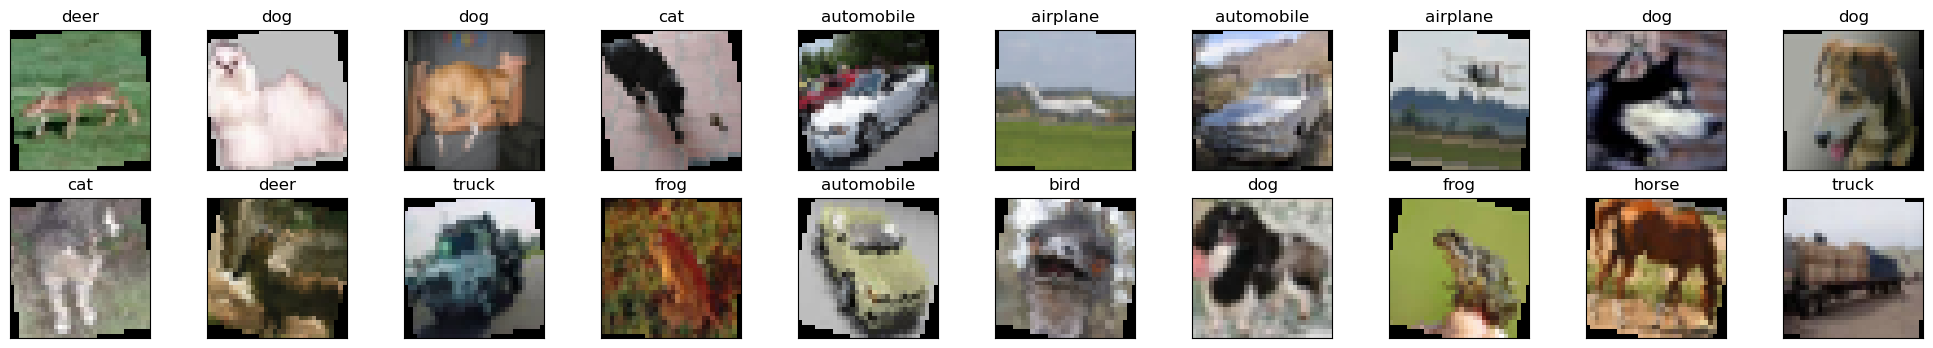

In [44]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

### View an Image in more detail

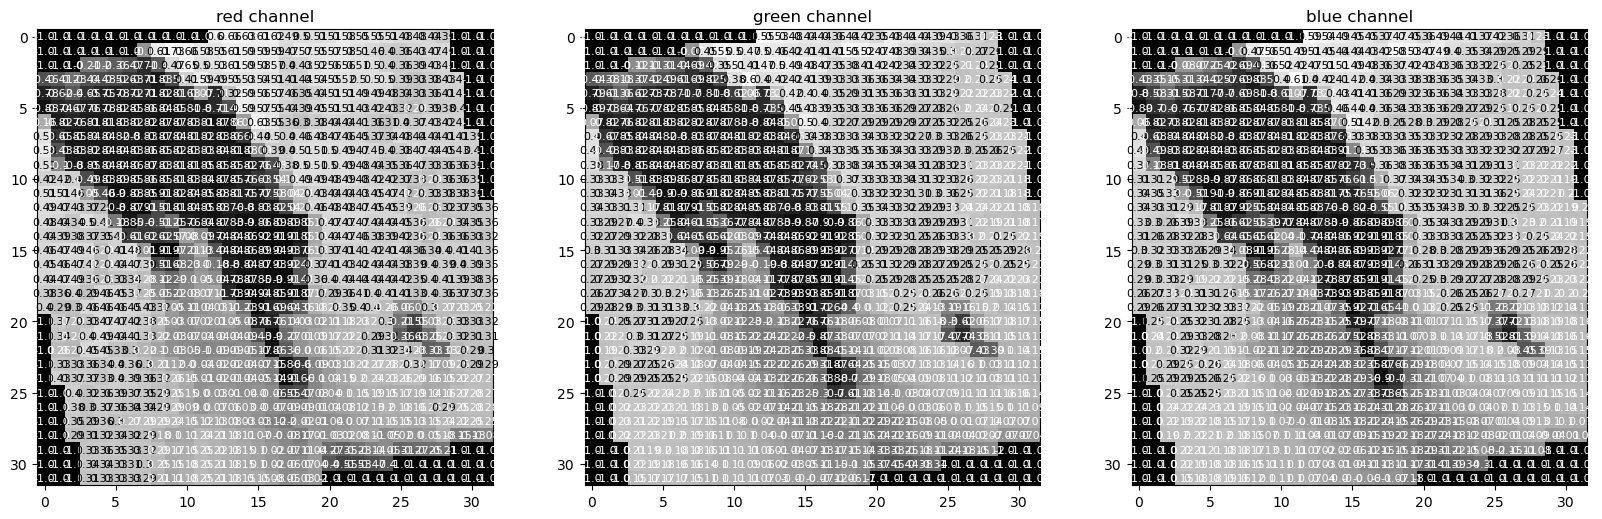

In [45]:
# This code visualizes the individual Red, Green, and Blue (RGB) channels of an image:
rgb_img = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (20, 20))
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1) # Creates a subplot for each channel.
    img = rgb_img[idx] # Extracts the individual channel.
    ax.imshow(img, cmap='gray')  # Displays the channel in grayscale.
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    # The nested for loops annotate each pixel in the channel images with its value,
    # adjusting the text color based on the pixel intensity (thresh).
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

## Define the Network Architecture

In [46]:
# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer
        # Three convolutional layers (conv1, conv2, conv3) with increasing number
        # of filters (16, 32, 64) and a kernel size of 3x3. Padding is set to 1.

        # The first argument specifies the number of input channels. For RGB images like
        # those in the CIFAR-10 dataset, this is 3 (Red, Green, Blue).
        # The second argument specifies the number of output channels (or filters). This
        # layer will have 16 filters that will learn different features from the input image.
        # The third argument specifies the size of the filter (also known as the kernel).
        # In this case, it's a 3x3 filter.
        # Padding: This argument specifies that a padding of 1 pixel will be added to each side
        # of the input. Padding is used to control the spatial dimensions of the output volume,
        # ensuring it matches the input volume in this case.

        # So, this layer takes an input with 3 channels (RGB) and applies 16 different 3x3 filters
        # to it, producing 16 output channels. The padding ensures that the output volume has
        # the same spatial dimensions as the input.
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)

        # The second convolutional layer self.conv2 = nn.Conv2d(16, 32, 3, padding=1) takes the
        # 16 output channels from the first convolutional layer (self.conv1) as its input channels.
        # It then produces 32 output channels using 3x3 filters, with a padding of 1 to maintain the spatial dimensions.
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)

        # The first argument specifies the number of input features to this layer. The 64 comes from the number of
        # output channels from the last convolutional layer
        # The 4*4 represents the spatial dimensions (height and width) of each of these 64 feature maps after they
        # have been processed by all the previous layers, including pooling layers.
        # The second argument specifies the number of output features (or neurons) in this fully connected layer.
        self.fc1 = nn.Linear(64*4*4, 256)
        self.fc2 = nn.Linear(256, 10)

        # Dropout is a regularization technique used to prevent overfitting in neural networks.
        # The argument specifies the dropout rate, which is the fraction of neurons to set to zero during training.
        # In this case, approximately 25% of the neurons' outputs will be set to zero during each forward pass.

        # During training, this layer randomly sets a subset of its input units to 0 at each step, which helps to
        # prevent overfitting. During evaluation or testing, the dropout layer is bypassed, and all neurons are used.
        self.dropout = nn.Dropout(0.25)

        # max pooling layer
        # A pooling layer is a layer in a neural network that performs a down-sampling operation, reducing the
        # spatial dimensions (height and width) of the input volume. This is done to decrease the computational
        # complexity, reduce overfitting, and provide a form of translational invariance.

        # The most common type of pooling is max pooling, where each unit in the output volume receives the maximum
        # value of a certain patch in the input volume. Other types of pooling include average pooling and min pooling.

        # So, this layer takes each 2x2 block of each feature map and keeps only the maximum value, effectively halving
        # the height and width of the feature maps, which can help to reduce computation and also add a form
        # of translational invariance to the network.
        # The first argument specifies the size of the window over which the maximum value will be taken. In this case, it's a 2x2 window.
        # The second argument specifies the stride, which is the step size the window takes as it moves across the input volume.
        # A stride of 2 means the window will skip one cell as it moves.
        self.pool = nn.MaxPool2d(2, 2)

    # The forward method defines the forward pass of the neural network, specifying how the input x is transformed into the output.
    def forward(self, x):
        # First convolutional layer is applied.
        # ReLU (Rectified Linear Unit) activation function is applied.
        # Max pooling is applied.
        x = self.pool(F.relu(self.conv1(x)))

        # this is repeated for conv2 and conv3
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        # The output tensor is reshaped (flattened) to feed into the fully connected layers. The -1 is a placeholder
        # for the batch size, and 64*4*4 is the number of features coming from the last convolutional layer.
        x = x.view(-1, 64*4*4)

        # Dropout is applied for regularization.
        x = self.dropout(x)

        # First fully connected layer is applied.
        # ReLU activation is applied.
        x = F.relu(self.fc1(x))

        # Dropout is applied again for regularization.
        x = self.dropout(x)

        # Second fully connected layer is applied to produce the final output.
        x = self.fc2(x)

        # The final output is returned, which can be used for classification.
        return x

# create a complete CNN
model = Net()
print(model)

# move tensors to GPU if CUDA is available
model.to(device)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

## Specify loss function and optimizer

In [47]:
# specify loss function
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=config.learning_rate)

## Train the Network

In [48]:
# GPU: 12m 59s
# CPU: 15m 55s

wandb.watch(model)

# number of epochs to train the model
n_epochs = config.epochs # you may increase this number to train a final model

valid_loss_min = np.Inf # track change in validation loss

start_time = time.time()
for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0

    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data.to(device))
        # calculate the batch loss
        loss = criterion(output, target.to(device))
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        # this line is accumulating the total training loss for the entire dataset,
        # not just the average loss for each mini-batch.
        # loss.item(): This gives you the scalar value of the loss for the current mini-batch.
        # data.size(0): This gives you the number of samples in the current mini-batch.
        # By multiplying these two together, you get the total loss for the current mini-batch.
        # Adding this to train_loss accumulates the loss over all mini-batches.
        train_loss += loss.item()*data.size(0)

    ######################
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors
        data.to(device)
        target.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data.to(device))
        # calculate the batch loss
        loss = criterion(output, target.to(device))
        # update average validation loss
        valid_loss += loss.item()*data.size(0)

    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)

    # print training/validation statistics
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    wandb.log({'epoch': epoch, 'loss': train_loss})

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

end_time = time.time()
print(f"Training took {end_time - start_time:.2f} seconds to run.")

Epoch: 1 	Training Loss: 1.719840 	Validation Loss: 0.380991
Validation loss decreased (inf --> 0.380991).  Saving model ...
Epoch: 2 	Training Loss: 1.417893 	Validation Loss: 0.310991
Validation loss decreased (0.380991 --> 0.310991).  Saving model ...
Epoch: 3 	Training Loss: 1.247806 	Validation Loss: 0.286608
Validation loss decreased (0.310991 --> 0.286608).  Saving model ...
Epoch: 4 	Training Loss: 1.165718 	Validation Loss: 0.277472
Validation loss decreased (0.286608 --> 0.277472).  Saving model ...
Epoch: 5 	Training Loss: 1.105299 	Validation Loss: 0.254410
Validation loss decreased (0.277472 --> 0.254410).  Saving model ...
Epoch: 6 	Training Loss: 1.051128 	Validation Loss: 0.243698
Validation loss decreased (0.254410 --> 0.243698).  Saving model ...
Epoch: 7 	Training Loss: 1.006049 	Validation Loss: 0.236735
Validation loss decreased (0.243698 --> 0.236735).  Saving model ...
Epoch: 8 	Training Loss: 0.971567 	Validation Loss: 0.231033
Validation loss decreased (0.23673

## Test the Trained Network

In [50]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data.to(device))
    # calculate the batch loss
    loss = criterion(output, target.to(device))
    # update test loss
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    # output is the tensor containing the raw score
    # the shape is typically (batch_size, num_classes)
    # torch.max(output, 1) --> returns 2 values: maximum value along the specified dimension
    # and the indices (class labels) where these maximum values occur
    # we are not interested in the first parameter (maximum raw score) but in the indices of
    # the maximum value, effectively representing the predicted class label
    # So, for each sample in the batch, torch.max looks at the output tensor, finds the maximum
    # value along the class dimension, and returns its index. This index corresponds to the
    # class label predicted by the model.
    _, pred = torch.max(output, 1)


    # compare predictions to true label
    # correct_tensor: This tensor will contain Boolean values (True or False) indicating
    # whether each prediction is correct.
    correct_tensor = pred.eq(target.to(device).data.view_as(pred))
    # Squeezing removes dimensions of size 1, making it easier to index the array.
    # correct: This will be a NumPy array containing 1s and 0s, where 1 indicates a correct
    # prediction and 0 indicates an incorrect prediction.
    correct = np.squeeze(correct_tensor.numpy()) if not device == 'cuda' else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(config.batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

wandb.log({"test_accuracy": 100. * np.sum(class_correct) / np.sum(class_total)})

Test Loss: 0.785883

Test Accuracy of airplane: 79% (798/1000)
Test Accuracy of automobile: 89% (892/1000)
Test Accuracy of  bird: 65% (654/1000)
Test Accuracy of   cat: 41% (419/1000)
Test Accuracy of  deer: 71% (716/1000)
Test Accuracy of   dog: 65% (650/1000)
Test Accuracy of  frog: 89% (890/1000)
Test Accuracy of horse: 74% (743/1000)
Test Accuracy of  ship: 72% (728/1000)
Test Accuracy of truck: 72% (722/1000)

Test Accuracy (Overall): 72% (7212/10000)


In [51]:
wandb.finish()

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▆▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
test_accuracy,▁
epoch,30
loss,0.61524
test_accuracy,72.12
